[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/Priesemann-Group/covid19_inference/blob/pymc4/scripts/interactive/example_paper_scenarios.ipynb)

In [ ]:
#optional (if not cloned i.e. running in colab)
# !pip install covid19_inference



# Non-hierarchical model using jhu data (no regions).
Reproduces Dehning et al. arXiv:2004.01105 Figure 3

Runtime ~ 15 min

In the new code we have implemented smoother transitions at the change points
via sigmoids instead of the linear transient.
This slightly changes the interpretation of the change-point onset time. In the
paper, it was the beginning of the change, now it is at the center (of the
sigmoid)


In [1]:
import datetime
import sys
import pymc as pm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
try:
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append("../../")
    import covid19_inference as cov19

In [3]:
bd = datetime.datetime(2020, 3, 2)
ed = datetime.datetime(2020, 4, 21)

In [4]:
jhu = cov19.data_retrieval.JHU(auto_download=True)
cum_cases = jhu.get_total(country="Germany", data_begin=bd, data_end=ed)
new_cases = jhu.get_new(country="Germany", data_begin=bd, data_end=ed)

INFO     [covid19_inference.data_retrieval._JHU] Successfully loaded data from local


In [5]:
params_model = dict(
    new_cases_obs=new_cases,
    data_begin=bd,
    fcast_len=28,
    diff_data_sim=16,
    N_population=83e6,
)

In [6]:
# Median of the prior for the delay in case reporting, we assumed 8 days
pr_delay = 8

In [7]:
change_points = [
    # mild distancing
    dict(
        pr_mean_date_transient=datetime.datetime(2020, 3, 9)
        # account for new implementation where transients_day is centered, not begin
        + datetime.timedelta(days=1.5),
        pr_median_transient_len=3,
        pr_sigma_transient_len=0.3,
        pr_sigma_date_transient=3,
        pr_median_lambda=0.2,
        pr_sigma_lambda=0.5,
    ),
    # strong distancing
    dict(
        pr_mean_date_transient=datetime.datetime(2020, 3, 16)
        + datetime.timedelta(days=1.5),
        pr_median_transient_len=3,
        pr_sigma_transient_len=0.3,
        pr_sigma_date_transient=1,
        pr_median_lambda=1 / 8,
        pr_sigma_lambda=0.5,
    ),
    # contact ban
    dict(
        pr_mean_date_transient=datetime.datetime(2020, 3, 23)
        + datetime.timedelta(days=1.5),
        pr_median_transient_len=3,
        pr_sigma_transient_len=0.3,
        pr_sigma_date_transient=1,
        pr_median_lambda=1 / 16,
        pr_sigma_lambda=0.5,
    ),
]



create a model instance from the parameters and change points from above.
Add further details.
Every variable we define in the `with ... as model`-context gets attached
to the model and becomes a variable in the inference data.


In [8]:
with cov19.Cov19Model(**params_model) as this_model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.model.lambda_t_with_sigmoids(
        pr_median_lambda_0=0.4,
        pr_sigma_lambda_0=0.5,
        change_points_list=change_points,
        name_lambda_t="lambda_t",  # Name for the variable in the trace
    )

    # Adds the recovery rate mu to the model as a random variable
    mu = pm.LogNormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

    # This builds a decorrelated prior for I_begin for faster inference. It is not
    # necessary to use it, one can simply remove it and use the default argument for
    # pr_I_begin in cov19.model.SIR
    prior_I = cov19.model.uncorrelated_prior_I(
        lambda_t_log=lambda_t_log,
        mu=mu,
        pr_median_delay=pr_delay,
        pr_sigma_I_begin=2,
        n_data_points_used=5,
    )

    # Use lambda_t_log and mu as parameters for the SIR model.
    # The SIR model generates the inferred new daily cases.
    new_cases = cov19.model.SIR(lambda_t_log=lambda_t_log, mu=mu, pr_I_begin=prior_I)

    # Delay the cases by a lognormal reporting delay and add them as a trace variable
    new_cases = cov19.model.delay_cases(
        cases=new_cases,
        name_cases="delayed_cases",
        pr_mean_of_median=pr_delay,
        pr_sigma_of_median=0.2,
        pr_median_of_width=0.3,
    )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = cov19.model.week_modulation(cases=new_cases, name_cases="new_cases")

    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(cases=new_cases)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation



## engage!
Reduce tune and/or draws to speed things up. Or increase for better statistics.


In [9]:
idata = pm.sample(model=this_model, tune=500, draws=1000, init="advi+adapt_diag")

Auto-assigning NUTS sampler...
INFO     [pymc] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc] Initializing NUTS using advi+adapt_diag...


Convergence achieved at 17200
INFO     [pymc.variational.inference] Convergence achieved at 17200
Interrupted at 17,199 [8%]: Average Loss = 555.98
INFO     [pymc.variational.inference] Interrupted at 17,199 [8%]: Average Loss = 555.98
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_0_log_, lambda_1_log_, lambda_2_log_, lambda_3_log_, transient_day_1, transient_day_2, transient_day_3, transient_len_1_raw_, transient_len_2_raw_, transient_len_3_raw_, mu, I_begin_ratio_log, delay_log, weekend_factor_log, offset_modulation_rad, sigma_obs]
INFO     [pymc] NUTS: [lambda_0_log_, lambda_1_log_, lambda_2_log_, lambda_3_log_, transient_day_1, transient_day_2, transient_day_3, transient_len_1_raw_, transient_len_2_raw_, transient_len_3_raw_, mu, I_begin_ratio_log, delay_log, weekend_factor_log, offset_modulation_rad, sigma_obs]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 1070 seconds.
INFO     [pymc] Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 1070 seconds.



## plotting


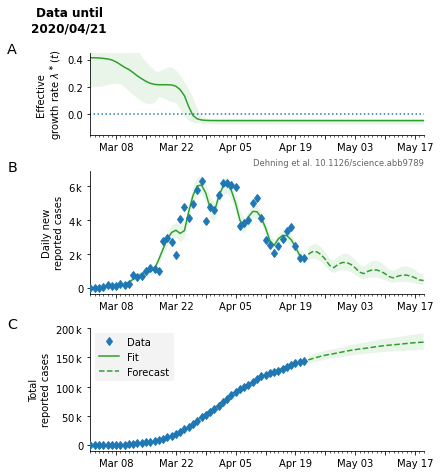

In [10]:
fig, axes = cov19.plot.timeseries_overview(this_model, idata, offset=cum_cases[0])

In [11]:
%%capture
fig, axes = plt.subplots(6, 3, figsize=(4, 6.4))
axes[0, 2].set_visible(False)
axes[1, 2].set_visible(False)

In [12]:
# left column
for i, (key, math) in enumerate(
    zip(["weekend_factor", "mu", "lambda_0", "lambda_1", "lambda_2", "lambda_3"],
    ["\Phi_w","\mu","\lambda_0", "\lambda_1", "\lambda_2", "\lambda_3"])
):
    cov19.plot.distribution(this_model, idata, key, ax=axes[i, 0], dist_math=math)

In [13]:
# mid column
for i, (key, math) in enumerate(
    zip([
        "offset_modulation",
        "sigma_obs",
        "I_begin",
        "transient_day_1",
        "transient_day_2",
        "transient_day_3",
    ],    [
        "f_w",
        "\sigma_{obs}",
        "I_0",
        "t_1",
        "t_2",
        "t_3",
    ])
):
    cov19.plot.distribution(this_model, idata, key, ax=axes[i, 1],dist_math=math,)

In [14]:
# right column
for i, (key,math) in enumerate(
    zip([
        "delay",
        "transient_len_1",
        "transient_len_2",
        "transient_len_3",
    ],[
        "D",
        "\Delta t_1",
        "\Delta t_2",
        "\Delta t_3"
    ])
):
    cov19.plot.distribution(this_model, idata, key, ax=axes[i + 2, 2],dist_math=math,)

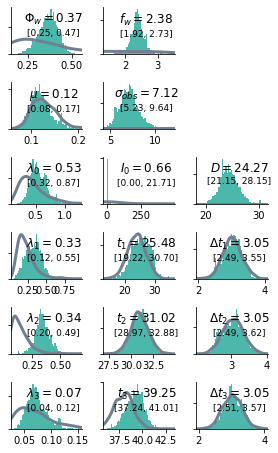

In [15]:
fig.tight_layout()
fig  # To show figure in jupyter notebook

In [16]:
%load_ext watermark
%watermark --iversions -v

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

matplotlib       : 3.5.2
pymc             : 4.0.1
sys              : 3.10.5 | packaged by conda-forge | (main, Jun 14 2022, 07:06:46) [GCC 10.3.0]
numpy            : 1.23.0
covid19_inference: 0.4.0

